# Постановка задачи

Исходя из тестового задания, нам нужно **реализовать модель для распознования текста с использованием глубокого обучения**

Для этого необходимо:
1. Выбрать датасет;
2. Подготовить датасет для обучения модели;
3. Реализовать модель для распознования текста;
4. Обучить модель на выборке;
5. Оценить производительность;


# 1. Выбор датасета

Изучая предложенную выборку из **` Kaggle `** Computer Vision, было решено остановиться на [**` Captcha Images `**](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images) по нескольким причинам:
1. Это интереснее, чем учить модель на **MNIST** или **CIFAR**, т.к. они часто используются в университетах;
2. Это не самый популярный, но при этом хорошо сформированный датасет;
3. Присутствует спортивный интерес с показателями модели, т.к. CAPTCHA размывает часть букв и имеет сторонние объекты;
4. Датасет аккуратно собран, но при этом есть небольшое пространство для подготовки перед обучением, чтобы улучшить результаты;

Сам по себе датасет состоит из черно-белых картинок с капчей, название которых информирует о том, какой текст содержится на изображении.

### *Почему не подошел датасет из задачи?*

В тестовом задании предложен [**` Topic Labeled News Dataset `**](https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset), однако, анализуя данные в нем, не совсем понятно как с ним работать. Датасет представляет собой csv файл со следующими категориями:
- topic;
- link;
- domain;
- published_date;
- title;
- lang;

Описание на **` Kaggle `** гласит что внутри нас ждут **100 000** ссылок на 8 разных типов новостей с доменом, датой публикации, заголовком и языком, это не то, что мы ожидали. Нам нужны картинки и подписи к ним для обучающей и тестовой выборки.


Возможно это ещё одна задача от авторов - **спарсить картинки с новостных сайтов и сформировать новый датасет...** Но открыв *первые попавшиеся 15-20 ссылок* мы видим обычные новости с фотографиями, а на тех немногих, где на картинке есть текст, отсутствует подпись с его дублированием... т.к. наша задача - написать модель для распознавания текста с картинки, то для формирования подходящего датасета из приведенного, потребуется огромное количество времени с ручным перепечатыванием текста с картинок.

Можно пойти другим, более хитрым путём - написать парсер, который делает скриншот статьи, копирует её текст и формирует csv файл с путём к скришоту и текстом на нём, но это всё ещё очень захламлённый датасет, например:
- Что если на сайте есть картинка с текстом без подписи?
- Что если на каких-то из ссылок возможность копировать текст будет заблокирована? Отслеживать post-get запросы? Искать JSON внутри кода статьи?
- Что если текст статьи больше скриншота?

И многие другие проблемы... т.е. датасет всё равно придётся просматривать и преобразовывать данные вручную, что займет огромное количество времени для 1 пункта тестового задания т.к. автоматизированная нормализация и другие инструменты преобразования данных не сильно улучшат картину.

### Подключение необходимого

Т.к. ограничений для работы с OCR по моделям и пакетам нет, я буду использовать [**`keras`**](https://keras.io/), потому что это относительно простой, но мощный инструмент с подробной документацией и большой экосистемой. 

In [45]:
# Подключение всего необходимого
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.regularizers import l2
from keras.utils import img_to_array

# 2. Подготовка датасета

Данные имеют несколько вещей, которые будут отвлекать нашу модель от сути, например:
- ЧБ градиент;
- Линии проходящие сквозь текст;
- "пустая" часть изображения, где нет необходимых нам символов;

Попробуем сделать с этим что-нибудь, используя **` OpenCV `**

Возьмём две картики и попробуем их улучшить:

In [46]:
img1_p = './data/8bbw8.png'
img2_p = './data/62fgn.jpg'

In [47]:
def show_pic(img1, img2):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, 'gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, 'gray')
    plt.axis('off')

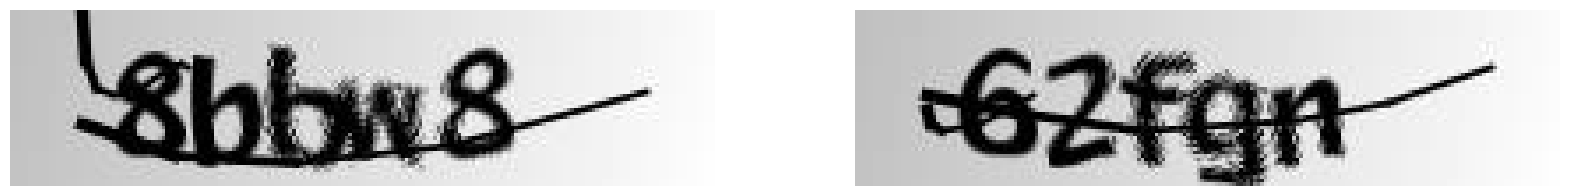

In [48]:
img1 = cv2.imread(img1_p, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_p, cv2.IMREAD_GRAYSCALE)

show_pic(img1, img2)

### Используем [**`Adaptive Treshholding`**](https://docs.opencv.org/4.7.0/d7/d4d/tutorial_py_thresholding.html) чтобы избавиться от градиента

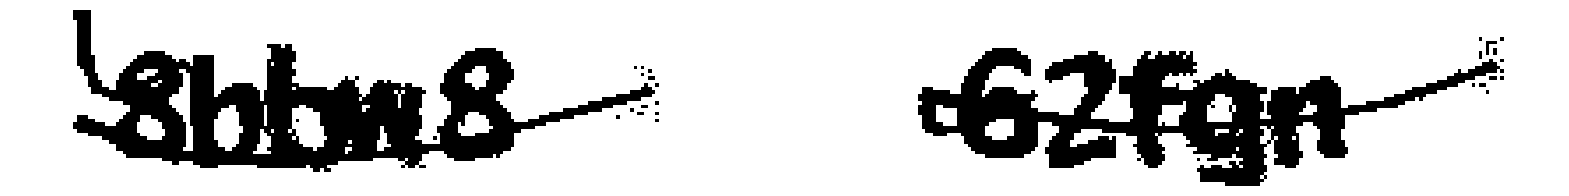

In [49]:
img1_atresh = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
img2_atresh = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

show_pic(img1_atresh, img2_atresh)

### Добавим [**`Closing и Delitation Morphological Transformations`**](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html) чтобы убрать шумы и сделать символы тоньше

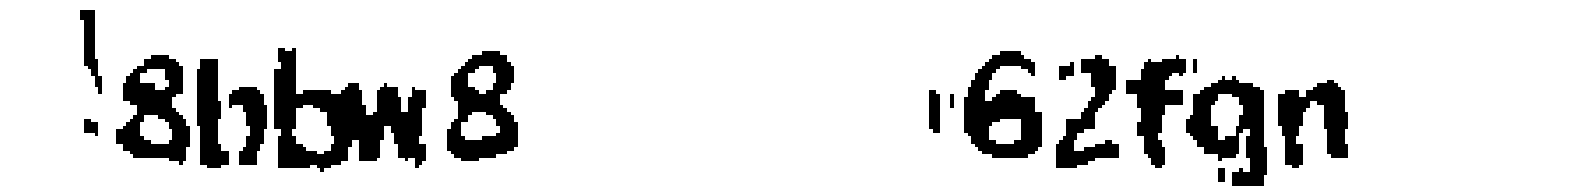

In [50]:
img1_closing = cv2.morphologyEx(img1_atresh, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
img2_closing = cv2.morphologyEx(img2_atresh, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

img1_closingD = cv2.dilate(img1_closing, np.ones((2,2),np.uint8), iterations = 1)
img2_closingD = cv2.dilate(img2_closing, np.ones((2,2),np.uint8), iterations = 1)

show_pic(img1_closingD, img2_closingD)

### В конце используем [**`Gaussian Blurring`**](https://docs.opencv.org/3.4/d4/d13/tutorial_py_filtering.html) чтобы немного "смазать" оставшиеся шумы

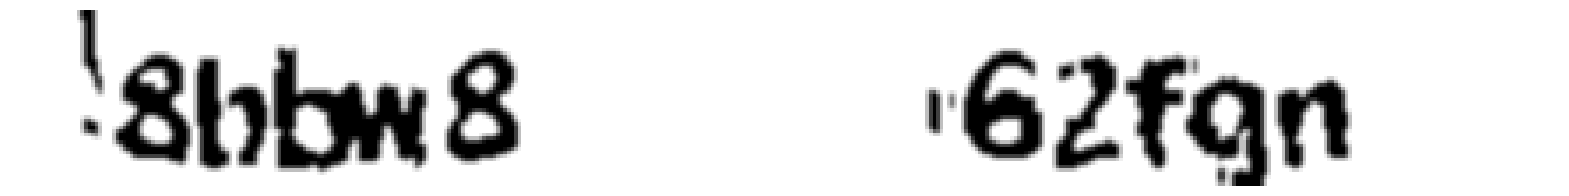

In [51]:
img1_gauss =cv2.GaussianBlur(img1_closingD, (3,3), 0)
img2_gauss = cv2.GaussianBlur(img2_closingD, (3,3), 0)
show_pic(img1_gauss, img2_gauss)

### Итог:

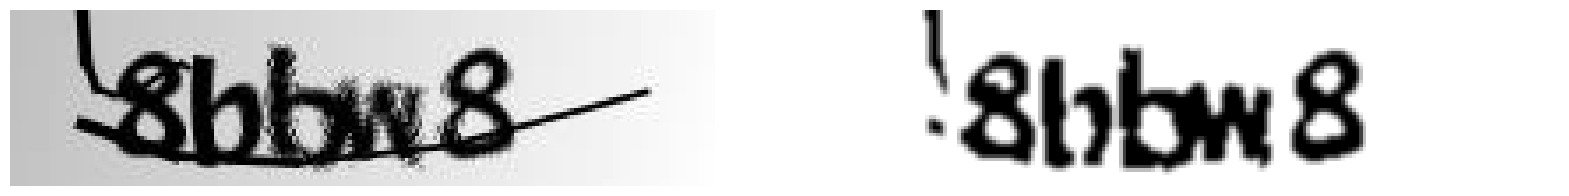

In [52]:
show_pic(img1, img1_gauss)

## Создаём новый датасет и связываем картинку с её лэйблом

Для начала создаём новый массив, куда записываем отредактированные сэмплы. У нас ещё нет сформированных связей для модели между картинкой и текстом, написанным на ней. Займёмся этим.

### Разметка изображения

Изначально я не планировал разделять капчу, т.к. положение символов весьма условное и при соблюдении одних и тех же границ 1-2 символа в среднем "разрезаются", однако есть сразу несколько причин, почему это всё же стоит сделать:
- из 1070 материалов для обучения мы получим 1070*5=**` 5350 `** и даже если ~25% из них будут с дефектом, модель получит в 4 раза больше чистых данных, чем изначально;
- вместо массива уникальных картинок мы получим определенное количество повторяющихся символов в разных вариациях;
- мы уменьшим размер изображения и увеличим процент *"полезных"* пикселей на 1 картинку;
- мы избавимся от части артефактов, находящихся вне разметки;


1 CAPTCHA :  2  ...  100 CAPTCHA :  2


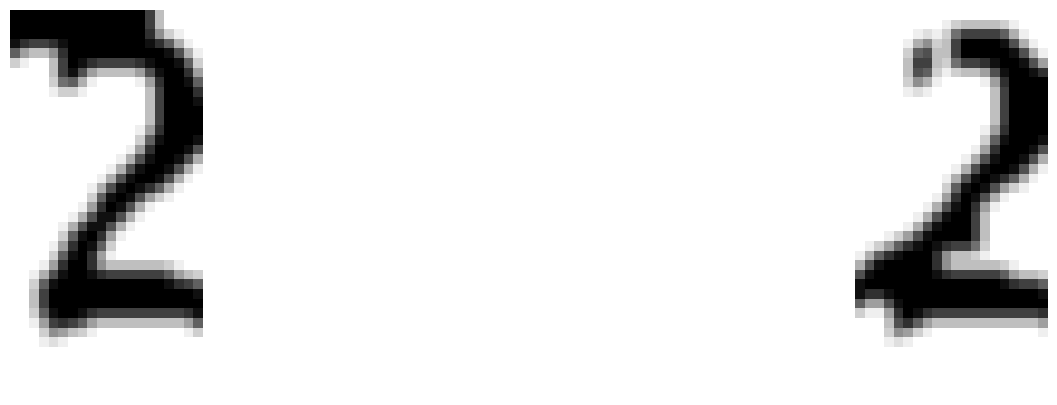

In [53]:
samples_x = []
labels_y = []

for dirname,_, filenames in os.walk('./data/'):
    for filename in filenames:
        path=os.path.join(dirname, filename) 
        new_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        new_img= cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
        new_img = cv2.morphologyEx(new_img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
        new_img = cv2.dilate(new_img, np.ones((2,2),np.uint8), iterations = 1)
        new_img = cv2.GaussianBlur(new_img, (3,3), 0)
        # нормализация
        new_img = cv2.normalize(new_img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Разрезаем изображение на 5 частей
        x=[new_img[10:50,30:50],new_img[10:50,50:70], new_img[10:50,70:90],new_img[10:50,90:110],new_img[10:50,110:130]]

        for i in range(5):
            samples_x.append(img_to_array(Image.fromarray(x[i])))
            labels_y.append(path[len(path)-9:len(path)-4][i])

samples_x = np.array(samples_x)
labels_y = np.array(labels_y)

show_pic(samples_x[0], samples_x[200])
print("1 CAPTCHA : ", labels_y[0]," ... ", "100 CAPTCHA : ", labels_y[200])


In [54]:
temp = set(labels_y)
print(str(len(temp)) + ' уникальных символов:')
for t in temp :
    print('Количество ' + '"' + t +'"'  + ' в датасете' + ' : ' + str(len(labels_y[labels_y == t])))


19 уникальных символов:
Количество "e" в датасете : 245
Количество "6" в датасете : 267
Количество "4" в датасете : 289
Количество "n" в датасете : 540
Количество "b" в датасете : 247
Количество "7" в датасете : 262
Количество "5" в датасете : 288
Количество "w" в датасете : 244
Количество "x" в датасете : 271
Количество "p" в датасете : 259
Количество "c" в датасете : 276
Количество "m" в датасете : 282
Количество "y" в датасете : 240
Количество "d" в датасете : 269
Количество "8" в датасете : 272
Количество "2" в датасете : 270
Количество "3" в датасете : 271
Количество "f" в датасете : 277
Количество "g" в датасете : 281


In [66]:
# One Hot Encoding

labels_y_le = LabelEncoder().fit_transform(labels_y)
labels_y_ohe = OneHotEncoder(sparse_output = False).fit_transform(labels_y_le.reshape(len(labels_y_le),1))
info = {labels_y_le[i] : labels_y[i] for i in range(len(labels_y))}

# разделение данных на Training(0.8) и Test(0.2)  

X_train, X_test, y_train, y_test = train_test_split(samples_x, labels_y_ohe, test_size = 0.2, random_state = 4)

row, col = samples_x.shape[1],samples_x.shape[2]
categories = labels_y_ohe.shape[1]
print(row, col, categories)


40 20 19


# 3. Реализация CNN Модели

При построении CNN модели я использую `Sequential()`, потому что это относительно легкий и понятный способ построить модель, после чего добавляю к ней 4 основных `Conv2D` слоя, где после 2 и 4 выключаю 1/5 всех нейронов, а так же 2 раза отключаю 0.4 и 0.2 нейронов в скрытом слое. Такая комбинация слоёв позволяет поддерживать баланс между показателями точности и функции потерь. Подробнее об этом я напишу при подведении итогов обучения.

In [56]:
model = Sequential()

model.add(Conv2D(32,(3,3), padding='same',  activation='relu', input_shape=(row,col,1)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01), activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, kernel_regularizer=l2(0.01), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(categories, kernel_regularizer=l2(0.01), activation="softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 40, 20, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 20, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 10, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 5, 32)        0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 10, 5, 32)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 10, 5, 64)        

In [57]:
# Если ошибка не уменьшается на протяжении указанного количества эпох, то процесс обучения прерывается и модель инициализируется весами с самым низким показателем параметра "monitor"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # указывается параметр, по которому осуществляется ранняя остановка. Обычно это функция потерь на валидационном наборе (val_loss)
    patience=10, # количество эпох по истечении которых закончится обучение, если показатели не улучшатся
    mode='min', # указывает, в какую сторону должна быть улучшена ошибка
    restore_best_weights=True # если параметр установлен в true, то по окончании обучения модель будет инициализирована весами с самым низким показателем параметра "monitor"
)

# Сохраняет модель для дальнейшей загрузки
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_model', # путь к папке, где будет сохранена модель
    monitor='val_loss',
    save_best_only=True, # если параметр установлен в true, то сохраняется только лучшая модель
    mode='min'
)

# Сохраняет логи выполнения обучения, которые можно будет посмотреть в специальной среде TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='log', # путь к папке где будут сохранены логи
)

history = model.fit(X_train, y_train,
                    batch_size=150, epochs=100, 
                    validation_data=(X_test, y_test),
                    shuffle=True, 
                    callbacks = [early_stopping, model_checkpoint,  tensorboard ])

Epoch 1/100
28/29 [===========================>..] - ETA: 0s - loss: 5.1993 - accuracy: 0.0676

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 5s 118ms/step - loss: 5.1864 - accuracy: 0.0680 - val_loss: 4.4765 - val_accuracy: 0.1084
Epoch 2/100
28/29 [===========================>..] - ETA: 0s - loss: 4.0636 - accuracy: 0.0979

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 4.0568 - accuracy: 0.0981 - val_loss: 3.6637 - val_accuracy: 0.1084
Epoch 3/100
28/29 [===========================>..] - ETA: 0s - loss: 3.2734 - accuracy: 0.1407

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 123ms/step - loss: 3.2668 - accuracy: 0.1423 - val_loss: 2.7479 - val_accuracy: 0.3121
Epoch 4/100
28/29 [===========================>..] - ETA: 0s - loss: 2.5817 - accuracy: 0.2967

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 3s 116ms/step - loss: 2.5732 - accuracy: 0.2998 - val_loss: 2.0819 - val_accuracy: 0.5065
Epoch 5/100
28/29 [===========================>..] - ETA: 0s - loss: 2.0743 - accuracy: 0.4502

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 3s 116ms/step - loss: 2.0678 - accuracy: 0.4509 - val_loss: 1.7153 - val_accuracy: 0.6243
Epoch 6/100
28/29 [===========================>..] - ETA: 0s - loss: 1.8011 - accuracy: 0.5405

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 3s 121ms/step - loss: 1.7987 - accuracy: 0.5418 - val_loss: 1.4837 - val_accuracy: 0.6570
Epoch 7/100
28/29 [===========================>..] - ETA: 0s - loss: 1.6065 - accuracy: 0.6014

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 3s 114ms/step - loss: 1.6066 - accuracy: 0.6012 - val_loss: 1.3307 - val_accuracy: 0.7318
Epoch 8/100
28/29 [===========================>..] - ETA: 0s - loss: 1.4299 - accuracy: 0.6633

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 3s 115ms/step - loss: 1.4281 - accuracy: 0.6652 - val_loss: 1.1847 - val_accuracy: 0.7682
Epoch 9/100
29/29 [==============================] - ETA: 0s - loss: 1.3002 - accuracy: 0.7100

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 134ms/step - loss: 1.3002 - accuracy: 0.7100 - val_loss: 1.0862 - val_accuracy: 0.7794
Epoch 10/100
29/29 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.7362

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 1.2177 - accuracy: 0.7362 - val_loss: 1.0329 - val_accuracy: 0.7925
Epoch 11/100
29/29 [==============================] - ETA: 0s - loss: 1.1514 - accuracy: 0.7451

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 132ms/step - loss: 1.1514 - accuracy: 0.7451 - val_loss: 0.9696 - val_accuracy: 0.8280
Epoch 12/100
28/29 [===========================>..] - ETA: 0s - loss: 1.0784 - accuracy: 0.7695

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 129ms/step - loss: 1.0766 - accuracy: 0.7703 - val_loss: 0.8971 - val_accuracy: 0.8355
Epoch 13/100
28/29 [===========================>..] - ETA: 0s - loss: 1.0174 - accuracy: 0.7838

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 136ms/step - loss: 1.0212 - accuracy: 0.7832 - val_loss: 0.8771 - val_accuracy: 0.8458
Epoch 14/100
28/29 [===========================>..] - ETA: 0s - loss: 0.9753 - accuracy: 0.7974

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.9781 - accuracy: 0.7965 - val_loss: 0.8260 - val_accuracy: 0.8551
Epoch 15/100
28/29 [===========================>..] - ETA: 0s - loss: 0.9260 - accuracy: 0.8090

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.9250 - accuracy: 0.8096 - val_loss: 0.8182 - val_accuracy: 0.8542
Epoch 16/100
29/29 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 0.8058

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 129ms/step - loss: 0.9199 - accuracy: 0.8058 - val_loss: 0.7877 - val_accuracy: 0.8477
Epoch 17/100
29/29 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.8189

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 136ms/step - loss: 0.8683 - accuracy: 0.8189 - val_loss: 0.7695 - val_accuracy: 0.8626
Epoch 18/100
28/29 [===========================>..] - ETA: 0s - loss: 0.8533 - accuracy: 0.8231

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 126ms/step - loss: 0.8505 - accuracy: 0.8241 - val_loss: 0.7549 - val_accuracy: 0.8589
Epoch 19/100
28/29 [===========================>..] - ETA: 0s - loss: 0.8334 - accuracy: 0.8281

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.8313 - accuracy: 0.8283 - val_loss: 0.7457 - val_accuracy: 0.8589
Epoch 20/100
29/29 [==============================] - ETA: 0s - loss: 0.8061 - accuracy: 0.8369

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 131ms/step - loss: 0.8061 - accuracy: 0.8369 - val_loss: 0.7354 - val_accuracy: 0.8636
Epoch 21/100
28/29 [===========================>..] - ETA: 0s - loss: 0.7992 - accuracy: 0.8369

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 135ms/step - loss: 0.7970 - accuracy: 0.8374 - val_loss: 0.7235 - val_accuracy: 0.8636
Epoch 22/100
28/29 [===========================>..] - ETA: 0s - loss: 0.7586 - accuracy: 0.8462

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 129ms/step - loss: 0.7612 - accuracy: 0.8449 - val_loss: 0.7045 - val_accuracy: 0.8682
Epoch 23/100
28/29 [===========================>..] - ETA: 0s - loss: 0.7563 - accuracy: 0.8488

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.7589 - accuracy: 0.8481 - val_loss: 0.6771 - val_accuracy: 0.8794
Epoch 24/100
29/29 [==============================] - 3s 91ms/step - loss: 0.7567 - accuracy: 0.8437 - val_loss: 0.6962 - val_accuracy: 0.8729
Epoch 25/100
29/29 [==============================] - 3s 90ms/step - loss: 0.7491 - accuracy: 0.8442 - val_loss: 0.7017 - val_accuracy: 0.8645
Epoch 26/100
28/29 [===========================>..] - ETA: 0s - loss: 0.7343 - accuracy: 0.8483

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 136ms/step - loss: 0.7309 - accuracy: 0.8495 - val_loss: 0.6567 - val_accuracy: 0.8720
Epoch 27/100
29/29 [==============================] - 3s 88ms/step - loss: 0.7022 - accuracy: 0.8512 - val_loss: 0.6692 - val_accuracy: 0.8701
Epoch 28/100
28/29 [===========================>..] - ETA: 0s - loss: 0.6900 - accuracy: 0.8567

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 130ms/step - loss: 0.6933 - accuracy: 0.8561 - val_loss: 0.6458 - val_accuracy: 0.8738
Epoch 29/100
28/29 [===========================>..] - ETA: 0s - loss: 0.6710 - accuracy: 0.8657

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.6695 - accuracy: 0.8661 - val_loss: 0.6342 - val_accuracy: 0.8822
Epoch 30/100
29/29 [==============================] - 3s 89ms/step - loss: 0.6730 - accuracy: 0.8540 - val_loss: 0.6465 - val_accuracy: 0.8766
Epoch 31/100
29/29 [==============================] - 3s 90ms/step - loss: 0.6687 - accuracy: 0.8638 - val_loss: 0.6418 - val_accuracy: 0.8729
Epoch 32/100
29/29 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.8647

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 132ms/step - loss: 0.6460 - accuracy: 0.8647 - val_loss: 0.6240 - val_accuracy: 0.8785
Epoch 33/100
28/29 [===========================>..] - ETA: 0s - loss: 0.6555 - accuracy: 0.8610

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 135ms/step - loss: 0.6572 - accuracy: 0.8593 - val_loss: 0.6109 - val_accuracy: 0.8794
Epoch 34/100
29/29 [==============================] - 3s 90ms/step - loss: 0.6334 - accuracy: 0.8647 - val_loss: 0.6277 - val_accuracy: 0.8757
Epoch 35/100
29/29 [==============================] - 3s 91ms/step - loss: 0.6248 - accuracy: 0.8675 - val_loss: 0.6253 - val_accuracy: 0.8813
Epoch 36/100
28/29 [===========================>..] - ETA: 0s - loss: 0.6213 - accuracy: 0.8693

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 130ms/step - loss: 0.6225 - accuracy: 0.8689 - val_loss: 0.6103 - val_accuracy: 0.8822
Epoch 37/100
28/29 [===========================>..] - ETA: 0s - loss: 0.6038 - accuracy: 0.8731

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 128ms/step - loss: 0.6043 - accuracy: 0.8734 - val_loss: 0.5994 - val_accuracy: 0.8832
Epoch 38/100
29/29 [==============================] - 3s 92ms/step - loss: 0.6015 - accuracy: 0.8750 - val_loss: 0.6012 - val_accuracy: 0.8869
Epoch 39/100
29/29 [==============================] - 3s 102ms/step - loss: 0.6014 - accuracy: 0.8731 - val_loss: 0.6008 - val_accuracy: 0.8860
Epoch 40/100
29/29 [==============================] - 3s 99ms/step - loss: 0.6014 - accuracy: 0.8717 - val_loss: 0.6055 - val_accuracy: 0.8776
Epoch 41/100
29/29 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.8750

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 147ms/step - loss: 0.5861 - accuracy: 0.8750 - val_loss: 0.5938 - val_accuracy: 0.8897
Epoch 42/100
29/29 [==============================] - 3s 88ms/step - loss: 0.5786 - accuracy: 0.8757 - val_loss: 0.6263 - val_accuracy: 0.8832
Epoch 43/100
28/29 [===========================>..] - ETA: 0s - loss: 0.5947 - accuracy: 0.8693

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 135ms/step - loss: 0.5950 - accuracy: 0.8685 - val_loss: 0.5849 - val_accuracy: 0.8897
Epoch 44/100
29/29 [==============================] - 3s 98ms/step - loss: 0.5769 - accuracy: 0.8757 - val_loss: 0.5850 - val_accuracy: 0.8822
Epoch 45/100
29/29 [==============================] - 3s 91ms/step - loss: 0.5664 - accuracy: 0.8811 - val_loss: 0.5945 - val_accuracy: 0.8897
Epoch 46/100
29/29 [==============================] - 3s 92ms/step - loss: 0.5742 - accuracy: 0.8729 - val_loss: 0.5914 - val_accuracy: 0.8813
Epoch 47/100
29/29 [==============================] - 3s 93ms/step - loss: 0.5466 - accuracy: 0.8876 - val_loss: 0.5865 - val_accuracy: 0.8888
Epoch 48/100
29/29 [==============================] - 3s 93ms/step - loss: 0.5436 - accuracy: 0.8860 - val_loss: 0.5860 - val_accuracy: 0.8860
Epoch 49/100
29/29 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.8860

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 134ms/step - loss: 0.5395 - accuracy: 0.8860 - val_loss: 0.5702 - val_accuracy: 0.8953
Epoch 50/100
29/29 [==============================] - 3s 91ms/step - loss: 0.5410 - accuracy: 0.8853 - val_loss: 0.6150 - val_accuracy: 0.8850
Epoch 51/100
29/29 [==============================] - 3s 94ms/step - loss: 0.5356 - accuracy: 0.8808 - val_loss: 0.5833 - val_accuracy: 0.8916
Epoch 52/100
29/29 [==============================] - 3s 93ms/step - loss: 0.5433 - accuracy: 0.8783 - val_loss: 0.5860 - val_accuracy: 0.8850
Epoch 53/100
29/29 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8897

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 133ms/step - loss: 0.5287 - accuracy: 0.8897 - val_loss: 0.5693 - val_accuracy: 0.8981
Epoch 54/100
28/29 [===========================>..] - ETA: 0s - loss: 0.5184 - accuracy: 0.8886

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 131ms/step - loss: 0.5184 - accuracy: 0.8888 - val_loss: 0.5642 - val_accuracy: 0.8963
Epoch 55/100
29/29 [==============================] - 3s 91ms/step - loss: 0.5325 - accuracy: 0.8822 - val_loss: 0.5656 - val_accuracy: 0.8991
Epoch 56/100
29/29 [==============================] - 3s 92ms/step - loss: 0.5250 - accuracy: 0.8888 - val_loss: 0.5909 - val_accuracy: 0.8776
Epoch 57/100
28/29 [===========================>..] - ETA: 0s - loss: 0.5374 - accuracy: 0.8855

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 142ms/step - loss: 0.5340 - accuracy: 0.8867 - val_loss: 0.5612 - val_accuracy: 0.8972
Epoch 58/100
29/29 [==============================] - 3s 94ms/step - loss: 0.5006 - accuracy: 0.8902 - val_loss: 0.5836 - val_accuracy: 0.8860
Epoch 59/100
29/29 [==============================] - 3s 95ms/step - loss: 0.5178 - accuracy: 0.8890 - val_loss: 0.5664 - val_accuracy: 0.8860
Epoch 60/100
29/29 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.8974

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 137ms/step - loss: 0.4845 - accuracy: 0.8974 - val_loss: 0.5528 - val_accuracy: 0.8963
Epoch 61/100
29/29 [==============================] - 3s 91ms/step - loss: 0.4945 - accuracy: 0.8963 - val_loss: 0.5620 - val_accuracy: 0.8925
Epoch 62/100
29/29 [==============================] - 3s 94ms/step - loss: 0.5053 - accuracy: 0.8886 - val_loss: 0.5687 - val_accuracy: 0.8916
Epoch 63/100
29/29 [==============================] - 3s 94ms/step - loss: 0.4904 - accuracy: 0.8986 - val_loss: 0.5710 - val_accuracy: 0.8860
Epoch 64/100
29/29 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.8900

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 137ms/step - loss: 0.4933 - accuracy: 0.8900 - val_loss: 0.5513 - val_accuracy: 0.9000
Epoch 65/100
29/29 [==============================] - 3s 104ms/step - loss: 0.5004 - accuracy: 0.8937 - val_loss: 0.5655 - val_accuracy: 0.8907
Epoch 66/100
29/29 [==============================] - 3s 101ms/step - loss: 0.4966 - accuracy: 0.8963 - val_loss: 0.5733 - val_accuracy: 0.8935
Epoch 67/100
29/29 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8949

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 157ms/step - loss: 0.4885 - accuracy: 0.8949 - val_loss: 0.5506 - val_accuracy: 0.8925
Epoch 68/100
29/29 [==============================] - 3s 95ms/step - loss: 0.4824 - accuracy: 0.8963 - val_loss: 0.5691 - val_accuracy: 0.8944
Epoch 69/100
29/29 [==============================] - 3s 98ms/step - loss: 0.4714 - accuracy: 0.8963 - val_loss: 0.5535 - val_accuracy: 0.8879
Epoch 70/100
29/29 [==============================] - 3s 96ms/step - loss: 0.4797 - accuracy: 0.9023 - val_loss: 0.5598 - val_accuracy: 0.8879
Epoch 71/100
29/29 [==============================] - 3s 96ms/step - loss: 0.4627 - accuracy: 0.8977 - val_loss: 0.5656 - val_accuracy: 0.8869
Epoch 72/100
29/29 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.9014

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 139ms/step - loss: 0.4652 - accuracy: 0.9014 - val_loss: 0.5480 - val_accuracy: 0.8888
Epoch 73/100
29/29 [==============================] - 3s 95ms/step - loss: 0.4631 - accuracy: 0.9005 - val_loss: 0.5503 - val_accuracy: 0.9009
Epoch 74/100
29/29 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.9009

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 139ms/step - loss: 0.4688 - accuracy: 0.9009 - val_loss: 0.5390 - val_accuracy: 0.8991
Epoch 75/100
29/29 [==============================] - 3s 94ms/step - loss: 0.4493 - accuracy: 0.9040 - val_loss: 0.5482 - val_accuracy: 0.9000
Epoch 76/100
29/29 [==============================] - 3s 99ms/step - loss: 0.4655 - accuracy: 0.9014 - val_loss: 0.5419 - val_accuracy: 0.8963
Epoch 77/100
29/29 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.9016

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 141ms/step - loss: 0.4528 - accuracy: 0.9016 - val_loss: 0.5349 - val_accuracy: 0.8972
Epoch 78/100
29/29 [==============================] - 3s 96ms/step - loss: 0.4384 - accuracy: 0.9077 - val_loss: 0.5544 - val_accuracy: 0.8963
Epoch 79/100
29/29 [==============================] - 3s 98ms/step - loss: 0.4628 - accuracy: 0.8972 - val_loss: 0.5418 - val_accuracy: 0.8981
Epoch 80/100
29/29 [==============================] - 3s 99ms/step - loss: 0.4423 - accuracy: 0.9058 - val_loss: 0.5358 - val_accuracy: 0.8963
Epoch 81/100
29/29 [==============================] - 3s 97ms/step - loss: 0.4361 - accuracy: 0.9084 - val_loss: 0.5385 - val_accuracy: 0.8944
Epoch 82/100
29/29 [==============================] - 3s 96ms/step - loss: 0.4536 - accuracy: 0.9007 - val_loss: 0.5423 - val_accuracy: 0.8916
Epoch 83/100
29/29 [==============================] - 3s 97ms/step - loss: 0.4196 - accuracy: 0.9147 - val_loss: 0.5638 - val_accuracy: 0.8953
Epoch 84/10

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


29/29 [==============================] - 4s 150ms/step - loss: 0.4266 - accuracy: 0.9054 - val_loss: 0.5279 - val_accuracy: 0.9000
Epoch 87/100
29/29 [==============================] - 3s 97ms/step - loss: 0.4298 - accuracy: 0.9124 - val_loss: 0.5481 - val_accuracy: 0.8963
Epoch 88/100
29/29 [==============================] - 3s 98ms/step - loss: 0.4139 - accuracy: 0.9110 - val_loss: 0.5329 - val_accuracy: 0.9056
Epoch 89/100
29/29 [==============================] - 3s 98ms/step - loss: 0.4262 - accuracy: 0.9077 - val_loss: 0.5582 - val_accuracy: 0.8991
Epoch 90/100
29/29 [==============================] - 3s 99ms/step - loss: 0.4262 - accuracy: 0.9058 - val_loss: 0.5477 - val_accuracy: 0.8953
Epoch 91/100
29/29 [==============================] - 3s 98ms/step - loss: 0.4233 - accuracy: 0.9110 - val_loss: 0.5413 - val_accuracy: 0.9019
Epoch 92/100
29/29 [==============================] - 3s 100ms/step - loss: 0.4118 - accuracy: 0.9117 - val_loss: 0.5468 - val_accuracy: 0.8925
Epoch 93/1

## Выводы по обучению модели

Во время работы с построением и обучением модели я столкнулся с неожиданно высокими показателями функции потерь, которые при точности 80-85 процентов выдавали потери от 0.8 до 1-5, что многовато для задачи OCR. Перепробовав около полторы сотни (150!) разных вариантов слоёв и их весов и все возможные вариации параметров преобразования данных, я так и не смог сильно улучшить этот показатель. 

*У меня есть одна догадка на этот счет, которую я не могу сейчас проверить. Возможно дело в моём GPU (у меня в ноутбуке нет дискретной видеокарты, а нейросети используют ядра GPU в работе). Когда я учился в Бельгии, то уже сталкивался с подобной проблемой, и у моих коллег по команде с картами NVIDIA обучение и результаты были лучше, чем на моём.*

Для теста я скачал несколько kaggle блокнотов с хорошими оценками и показателями точности/потерь = 0.85+/0.15-, но на моём ноутбуке их показатели были такими же или хуже моих. Точность была в районе 80%, а функция потерь в районе 0.6-0.8.

В конечном итоге я решил остановиться на текущей вариации модели, так как считаю её самой оптимальной с показателями точности 90% и потерями 0.55. Для сравнения.

```py
#лучшая модель с kaggle на моём устройстве:
29/29 [==============================] - 1s 44ms/step - loss: 0.3895 - accuracy: 0.8682 - val_loss: 0.5601 - val_accuracy: 0.8598
#при Trainable params: 142,387

#Моя модель:
29/29 [==============================] - 4s 150ms/step - loss: 0.4266 - accuracy: 0.9054 - val_loss: 0.5279 - val_accuracy: 0.9000
# при Trainable params: 115,699
```

**После отправки тестового я ради интереса перенесу блокнот на Google Collab, протестирую модель ещё раз и дополню блокнот.**

In [60]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

34/34 [==============================] - 0s 7ms/step - loss: 0.5279 - accuracy: 0.9000
Test loss: 0.5278866291046143
Test accuracy: 0.8999999761581421


# Тесты

In [71]:
def pred (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

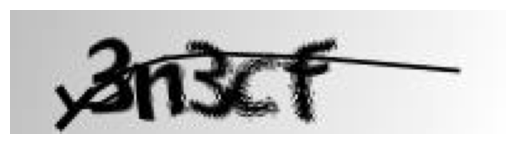

1/1 [==============================] - 0s 23ms/step
Prediction: 3n3cf
Actual:     3n3cf


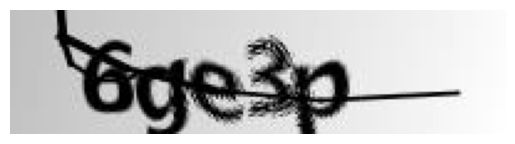

1/1 [==============================] - 0s 26ms/step
Prediction: 6g43p
Actual:     6ge3p


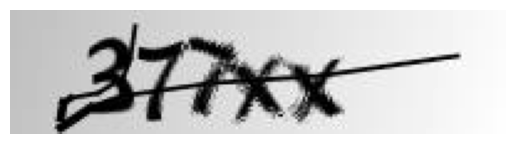

1/1 [==============================] - 0s 28ms/step
Prediction: 377xx
Actual:     377xx


In [78]:
pred('./data/3n3cf.png')
pred('./data/6ge3p.png')
pred('./data/377xx.png')